In [ ]:
!pip install segmentation-models-pytorch
!pip install albumentations

In [ ]:
!pip install Pillow

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch
import random
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [8]:
ROOT = "/kaggle/input/car-segment/final_dataset"
CLASSES = [
    "car"
]

ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 50
BATCH_SIZE = 32

INIT_LR = 0.0005
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2

INFER_WIDTH = 256
INFER_HEIGHT = 256

loss = smp.utils.losses.DiceLoss() + smp.utils.losses.BCELoss()

In [10]:
def visualize_single_mask(img, mask):
    if mask.ndim == 3:
        mask = mask.squeeze()

    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(img)
    axes[0].set_title("Изображение")
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Маска")

    plt.tight_layout()
    plt.show()

In [11]:
class CarDataset(Dataset):
    def __init__(
        self,
        file_names,
        augmentation=None,
        preprocessing=None
    ):
        self.images_paths = [ROOT + "/images/" + filename for filename in file_names]
        self.masks_paths = [ROOT + "/masks/" + filename for filename in file_names]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[i], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype('float32')
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images_paths)

In [12]:
file_names = [
    file_name for file_name in os.listdir(ROOT + "/images") if file_name.endswith(".png")
]
train_names, val_names = train_test_split(file_names, 
                                          test_size=0.2, 
                                          random_state=seed)
len(file_names), len(train_names), len(val_names)

(211, 168, 43)

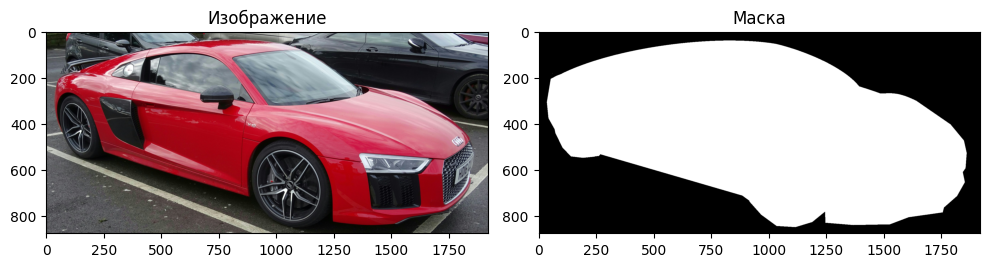

In [13]:
dataset = CarDataset(train_names)
image, mask = dataset[np.random.randint(len(dataset))]
visualize_single_mask(image, mask)

In [14]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.LongestMaxSize(max_size=INFER_HEIGHT),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH),

        albu.OneOf(
            [
                albu.Blur(blur_limit=[1, 3], p=0.5),
                albu.GaussNoise(var_limit=(1, 5), p=0.5),
            ],
            p=0.7,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
            ],
            p=0.7
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

libpng warning: iCCP: known incorrect sRGB profile


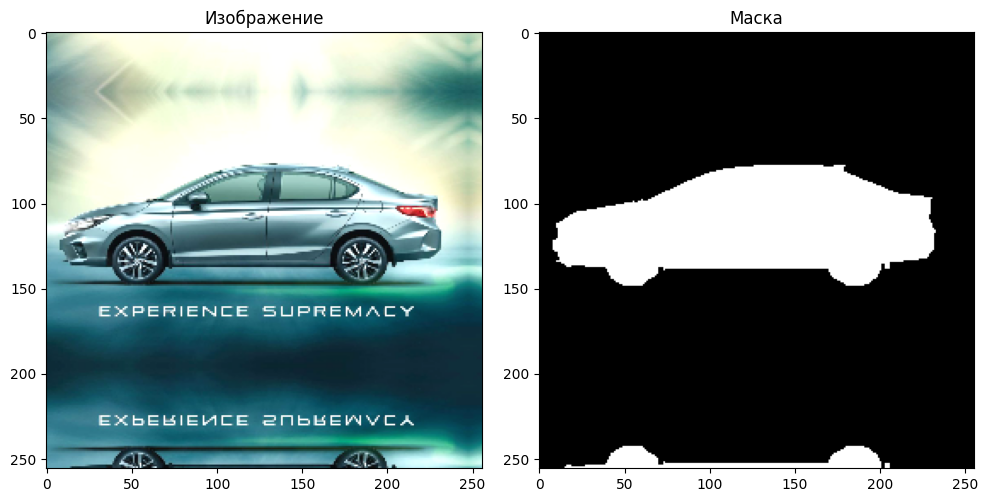

libpng warning: iCCP: known incorrect sRGB profile


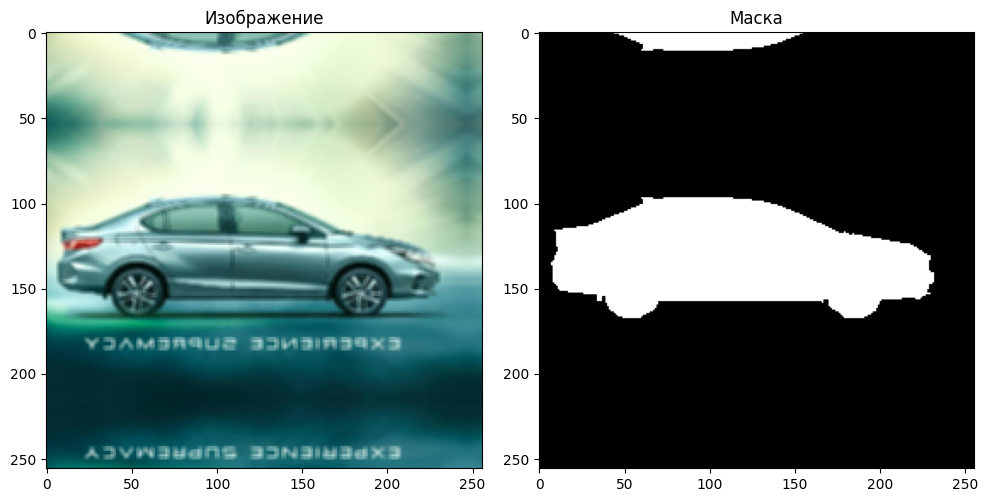

libpng warning: iCCP: known incorrect sRGB profile


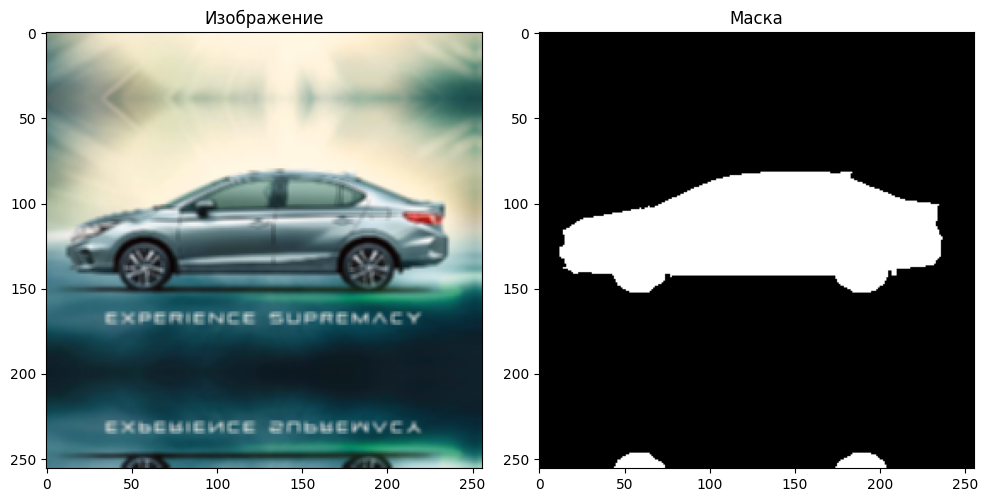

In [15]:
augmented_dataset = CarDataset(
    train_names, 
    augmentation=get_training_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

for i in range(3):
    image, mask = augmented_dataset[indx]
    visualize_single_mask(image, mask)

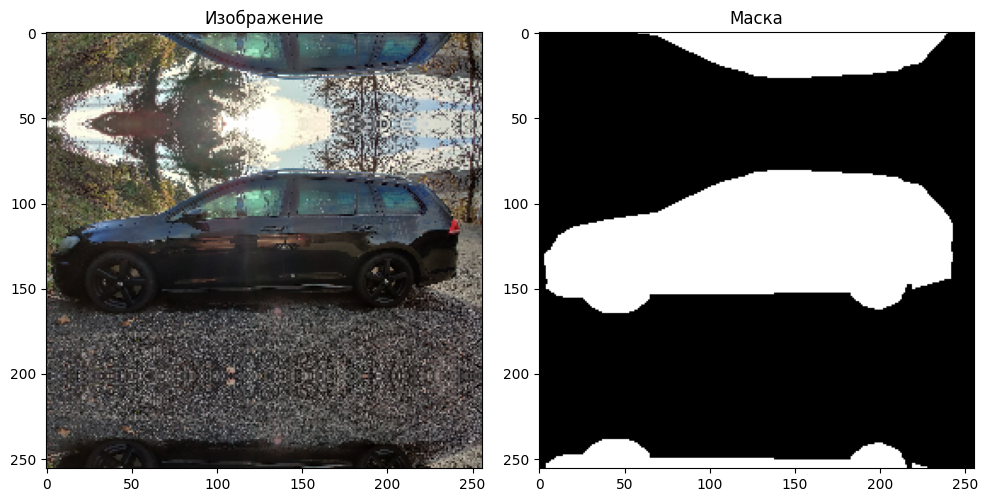

In [16]:
augmented_dataset = CarDataset(
    val_names, 
    augmentation=get_validation_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

image, mask = augmented_dataset[indx]
visualize_single_mask(image, mask)

In [17]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
model

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
preprocessing_fn

functools.partial(<function preprocess_input at 0x7c06d9dc8180>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [19]:
train_dataset = CarDataset(
    train_names, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = CarDataset(
    val_names, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [20]:
metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=INIT_LR),
])

In [21]:
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [22]:
max_score = 0

loss_logs = {"train": [], "val": []}
metric_logs = {"train": [], "val": []}
for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    train_loss, train_metric, train_metric_IOU = list(train_logs.values())
    loss_logs["train"].append(train_loss)
    metric_logs["train"].append(train_metric_IOU)

    valid_logs = valid_epoch.run(valid_loader)
    val_loss, val_metric, val_metric_IOU = list(valid_logs.values())
    loss_logs["val"].append(val_loss)
    metric_logs["val"].append(val_metric_IOU)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/kaggle/working/best_unet_model.pth')
        trace_image = torch.randn(BATCH_SIZE, 3, INFER_HEIGHT, INFER_WIDTH)
        traced_model = torch.jit.trace(model, trace_image.to(DEVICE))
        torch.jit.save(traced_model, '/kaggle/working/best_unet_model.pth')
        print('Model saved!')

    print("LR:", optimizer.param_groups[0]['lr'])
    if i > 0 and i % LR_DECREASE_STEP == 0:
        print('Decrease decoder learning rate')
        optimizer.param_groups[0]['lr'] /= LR_DECREASE_COEF


Epoch: 0
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:04<00:42,  4.29s/it, dice_loss + bce_loss - 1.55, fscore - 0.3158, iou_score - 0.1875]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:11<00:20,  2.95s/it, dice_loss + bce_loss - 1.291, fscore - 0.4868, iou_score - 0.3279]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:13<00:15,  2.55s/it, dice_loss + bce_loss - 1.243, fscore - 0.5172, iou_score - 0.3563]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:15<00:11,  2.30s/it, dice_loss + bce_loss - 1.202, fscore - 0.5439, iou_score - 0.3822]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:19<00:06,  2.28s/it, dice_loss + bce_loss - 1.135, fscore - 0.5856, iou_score - 0.4245]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:03<00:00, 13.09it/s, dice_loss + bce_loss - 1.094, fscore - 0.694, iou_score - 0.5401] 
Model saved!
LR: 0.0005

Epoch: 1
train:   9%|▉         | 1/11 [00:02<00:25,  2.58s/it, dice_loss + bce_loss - 0.7839, fscore - 0.7764, iou_score - 0.6345]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:15,  1.95s/it, dice_loss + bce_loss - 0.7404, fscore - 0.7983, iou_score - 0.6649]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:08<00:16,  2.35s/it, dice_loss + bce_loss - 0.7119, fscore - 0.8136, iou_score - 0.6872]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:11<00:13,  2.30s/it, dice_loss + bce_loss - 0.6935, fscore - 0.8212, iou_score - 0.698] 

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:13<00:06,  1.66s/it, dice_loss + bce_loss - 0.6786, fscore - 0.8262, iou_score - 0.7049]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:16<00:03,  1.60s/it, dice_loss + bce_loss - 0.6511, fscore - 0.8396, iou_score - 0.7253]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.75it/s, dice_loss + bce_loss - 0.7563, fscore - 0.8125, iou_score - 0.6918]
Model saved!
LR: 0.0005

Epoch: 2
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:14,  1.62s/it, dice_loss + bce_loss - 0.5021, fscore - 0.9016, iou_score - 0.8209]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:08<00:16,  2.38s/it, dice_loss + bce_loss - 0.4793, fscore - 0.9102, iou_score - 0.8354]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:10<00:13,  2.21s/it, dice_loss + bce_loss - 0.4782, fscore - 0.9073, iou_score - 0.8306]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:08,  1.78s/it, dice_loss + bce_loss - 0.477, fscore - 0.9028, iou_score - 0.8232] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:01,  1.69s/it, dice_loss + bce_loss - 0.4928, fscore - 0.8926, iou_score - 0.8072]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.93it/s, dice_loss + bce_loss - 0.4936, fscore - 0.8885, iou_score - 0.808] 
Model saved!
LR: 0.0005

Epoch: 3
train:  18%|█▊        | 2/11 [00:02<00:09,  1.11s/it, dice_loss + bce_loss - 0.4504, fscore - 0.8974, iou_score - 0.815] 

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:11,  1.63s/it, dice_loss + bce_loss - 0.43, fscore - 0.9097, iou_score - 0.8352]  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:08<00:11,  1.84s/it, dice_loss + bce_loss - 0.4161, fscore - 0.9162, iou_score - 0.8462]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:14<00:09,  2.37s/it, dice_loss + bce_loss - 0.4076, fscore - 0.918, iou_score - 0.849]  

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:18<00:04,  2.27s/it, dice_loss + bce_loss - 0.392, fscore - 0.9214, iou_score - 0.8549] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.20it/s, dice_loss + bce_loss - 0.3378, fscore - 0.935, iou_score - 0.885]  
Model saved!
LR: 0.0005

Epoch: 4
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:15,  1.67s/it, dice_loss + bce_loss - 0.3414, fscore - 0.9269, iou_score - 0.8639]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:11,  1.67s/it, dice_loss + bce_loss - 0.3277, fscore - 0.929, iou_score - 0.8676] 

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:10,  2.04s/it, dice_loss + bce_loss - 0.3267, fscore - 0.9289, iou_score - 0.8675]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:06,  2.12s/it, dice_loss + bce_loss - 0.3285, fscore - 0.9288, iou_score - 0.8672]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:16<00:03,  1.95s/it, dice_loss + bce_loss - 0.3277, fscore - 0.9295, iou_score - 0.8685]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.29it/s, dice_loss + bce_loss - 0.2968, fscore - 0.9398, iou_score - 0.8951]
Model saved!
LR: 0.0005

Epoch: 5
train:   9%|▉         | 1/11 [00:02<00:21,  2.16s/it, dice_loss + bce_loss - 0.292, fscore - 0.9481, iou_score - 0.9013]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:18,  2.27s/it, dice_loss + bce_loss - 0.2778, fscore - 0.9467, iou_score - 0.8988]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:08<00:14,  2.03s/it, dice_loss + bce_loss - 0.2843, fscore - 0.9433, iou_score - 0.8927]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:10<00:11,  1.92s/it, dice_loss + bce_loss - 0.2786, fscore - 0.9434, iou_score - 0.8929]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:12<00:10,  2.09s/it, dice_loss + bce_loss - 0.2766, fscore - 0.9435, iou_score - 0.8932]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.76s/it, dice_loss + bce_loss - 0.2919, fscore - 0.9351, iou_score - 0.8785]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.80it/s, dice_loss + bce_loss - 0.2807, fscore - 0.9358, iou_score - 0.8896]
LR: 0.0005

Epoch: 6
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:15,  1.53s/it, dice_loss + bce_loss - 0.2459, fscore - 0.941, iou_score - 0.8886]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:16,  1.82s/it, dice_loss + bce_loss - 0.2528, fscore - 0.9428, iou_score - 0.8919]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:04<00:12,  1.60s/it, dice_loss + bce_loss - 0.2493, fscore - 0.9421, iou_score - 0.8905]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:09,  1.42s/it, dice_loss + bce_loss - 0.2407, fscore - 0.9461, iou_score - 0.8977]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:09<00:07,  1.59s/it, dice_loss + bce_loss - 0.2372, fscore - 0.9474, iou_score - 0.9001]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:12<00:07,  1.88s/it, dice_loss + bce_loss - 0.2532, fscore - 0.9405, iou_score - 0.8883]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.01it/s, dice_loss + bce_loss - 0.2441, fscore - 0.9415, iou_score - 0.8984]
Model saved!
LR: 0.0005

Epoch: 7
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:18,  2.05s/it, dice_loss + bce_loss - 0.25, fscore - 0.9408, iou_score - 0.8882]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:19,  2.45s/it, dice_loss + bce_loss - 0.2419, fscore - 0.9417, iou_score - 0.8898]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:08<00:15,  2.18s/it, dice_loss + bce_loss - 0.2352, fscore - 0.944, iou_score - 0.8939] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:08,  1.79s/it, dice_loss + bce_loss - 0.2399, fscore - 0.9406, iou_score - 0.8879]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:13<00:06,  1.73s/it, dice_loss + bce_loss - 0.2304, fscore - 0.9438, iou_score - 0.8939]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.59it/s, dice_loss + bce_loss - 0.2124, fscore - 0.9491, iou_score - 0.9124]
Model saved!
LR: 0.0005

Epoch: 8
train:   9%|▉         | 1/11 [00:02<00:29,  2.94s/it, dice_loss + bce_loss - 0.1627, fscore - 0.9672, iou_score - 0.9364]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:15,  1.95s/it, dice_loss + bce_loss - 0.1894, fscore - 0.9553, iou_score - 0.9145]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:08<00:13,  1.90s/it, dice_loss + bce_loss - 0.1922, fscore - 0.9544, iou_score - 0.9129]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:09,  1.84s/it, dice_loss + bce_loss - 0.1938, fscore - 0.9552, iou_score - 0.9143]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.86s/it, dice_loss + bce_loss - 0.1896, fscore - 0.9559, iou_score - 0.9157]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.61it/s, dice_loss + bce_loss - 0.2045, fscore - 0.9505, iou_score - 0.915] 
Model saved!
LR: 0.0005

Epoch: 9
train:   9%|▉         | 1/11 [00:00<00:07,  1.40it/s, dice_loss + bce_loss - 0.1634, fscore - 0.9619, iou_score - 0.9267]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:01<00:09,  1.02s/it, dice_loss + bce_loss - 0.1541, fscore - 0.9654, iou_score - 0.9332]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:03<00:08,  1.04s/it, dice_loss + bce_loss - 0.1542, fscore - 0.9654, iou_score - 0.9332]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:14,  2.14s/it, dice_loss + bce_loss - 0.1542, fscore - 0.9652, iou_score - 0.9327]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:08<00:12,  2.11s/it, dice_loss + bce_loss - 0.1543, fscore - 0.9653, iou_score - 0.9329]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:14<00:06,  2.06s/it, dice_loss + bce_loss - 0.1616, fscore - 0.9618, iou_score - 0.9264]

libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:01,  1.96s/it, dice_loss + bce_loss - 0.1609, fscore - 0.9615, iou_score - 0.9259]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.99it/s, dice_loss + bce_loss - 0.192, fscore - 0.9438, iou_score - 0.9024] 
LR: 0.0005

Epoch: 10
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:15,  1.60s/it, dice_loss + bce_loss - 0.1515, fscore - 0.9624, iou_score - 0.9275]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:07<00:09,  1.65s/it, dice_loss + bce_loss - 0.1488, fscore - 0.9637, iou_score - 0.93]  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:10<00:09,  1.93s/it, dice_loss + bce_loss - 0.147, fscore - 0.964, iou_score - 0.9305]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:12<00:08,  2.10s/it, dice_loss + bce_loss - 0.1455, fscore - 0.9646, iou_score - 0.9317]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:18<00:04,  2.27s/it, dice_loss + bce_loss - 0.1442, fscore - 0.9647, iou_score - 0.9317]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.75it/s, dice_loss + bce_loss - 0.1609, fscore - 0.9544, iou_score - 0.9187]
Model saved!
LR: 0.0005

Epoch: 11
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:16,  1.67s/it, dice_loss + bce_loss - 0.1557, fscore - 0.9586, iou_score - 0.9205]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:07<00:13,  1.92s/it, dice_loss + bce_loss - 0.1503, fscore - 0.9604, iou_score - 0.9238]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:14<00:09,  2.38s/it, dice_loss + bce_loss - 0.1587, fscore - 0.958, iou_score - 0.9196] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:01,  1.83s/it, dice_loss + bce_loss - 0.1589, fscore - 0.9573, iou_score - 0.9182]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.25it/s, dice_loss + bce_loss - 0.1545, fscore - 0.9558, iou_score - 0.9217]
Model saved!
LR: 0.0005

Epoch: 12
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:03<00:37,  3.72s/it, dice_loss + bce_loss - 0.1369, fscore - 0.9627, iou_score - 0.9281]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:15,  1.92s/it, dice_loss + bce_loss - 0.1262, fscore - 0.967, iou_score - 0.9361] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:08<00:13,  1.88s/it, dice_loss + bce_loss - 0.1303, fscore - 0.9651, iou_score - 0.9325]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:09<00:09,  1.59s/it, dice_loss + bce_loss - 0.1337, fscore - 0.9643, iou_score - 0.9311]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:10<00:07,  1.48s/it, dice_loss + bce_loss - 0.138, fscore - 0.9629, iou_score - 0.9285] 

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.81s/it, dice_loss + bce_loss - 0.1403, fscore - 0.9625, iou_score - 0.9277]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.56it/s, dice_loss + bce_loss - 0.1557, fscore - 0.9536, iou_score - 0.9202]
LR: 0.0005

Epoch: 13
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:15,  1.98s/it, dice_loss + bce_loss - 0.1414, fscore - 0.9606, iou_score - 0.9242]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:08<00:16,  2.38s/it, dice_loss + bce_loss - 0.1465, fscore - 0.9589, iou_score - 0.9212]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:09<00:11,  2.00s/it, dice_loss + bce_loss - 0.1466, fscore - 0.9587, iou_score - 0.9207]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:15<00:09,  2.40s/it, dice_loss + bce_loss - 0.143, fscore - 0.9603, iou_score - 0.9237] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:16<00:06,  2.06s/it, dice_loss + bce_loss - 0.1483, fscore - 0.9586, iou_score - 0.9205]

libpng warning: iCCP: known incorrect sRGB profile


train: 100%|██████████| 11/11 [00:19<00:00,  1.78s/it, dice_loss + bce_loss - 0.1484, fscore - 0.9583, iou_score - 0.9201]

libpng warning: iCCP: known incorrect sRGB profile



valid: 100%|██████████| 43/43 [00:02<00:00, 17.81it/s, dice_loss + bce_loss - 0.1521, fscore - 0.9539, iou_score - 0.9198]
LR: 0.0005

Epoch: 14
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:19,  1.96s/it, dice_loss + bce_loss - 0.1326, fscore - 0.9629, iou_score - 0.9284]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:13,  1.54s/it, dice_loss + bce_loss - 0.122, fscore - 0.9669, iou_score - 0.936]  

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:10,  1.52s/it, dice_loss + bce_loss - 0.1264, fscore - 0.9651, iou_score - 0.9326]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:07<00:08,  1.35s/it, dice_loss + bce_loss - 0.1321, fscore - 0.9634, iou_score - 0.9294]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:11<00:06,  1.65s/it, dice_loss + bce_loss - 0.1437, fscore - 0.9587, iou_score - 0.9208]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:14<00:06,  2.22s/it, dice_loss + bce_loss - 0.1393, fscore - 0.9604, iou_score - 0.9239]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train: 100%|██████████| 11/11 [00:19<00:00,  1.75s/it, dice_loss + bce_loss - 0.138, fscore - 0.9608, iou_score - 0.9247] 

libpng warning: iCCP: known incorrect sRGB profile



valid: 100%|██████████| 43/43 [00:02<00:00, 18.04it/s, dice_loss + bce_loss - 0.1661, fscore - 0.95, iou_score - 0.9147]  
LR: 0.0005

Epoch: 15
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:02<00:22,  2.21s/it, dice_loss + bce_loss - 0.1215, fscore - 0.9675, iou_score - 0.937]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:12,  1.60s/it, dice_loss + bce_loss - 0.1227, fscore - 0.9669, iou_score - 0.9358]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:11,  1.66s/it, dice_loss + bce_loss - 0.1197, fscore - 0.9677, iou_score - 0.9374]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:08<00:09,  1.55s/it, dice_loss + bce_loss - 0.122, fscore - 0.9667, iou_score - 0.9356] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:15<00:03,  1.84s/it, dice_loss + bce_loss - 0.121, fscore - 0.9667, iou_score - 0.9355] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:01,  2.00s/it, dice_loss + bce_loss - 0.1204, fscore - 0.9667, iou_score - 0.9356]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.58it/s, dice_loss + bce_loss - 0.1419, fscore - 0.9556, iou_score - 0.9241] 
Model saved!
LR: 0.0005
Decrease decoder learning rate

Epoch: 16
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:14,  1.62s/it, dice_loss + bce_loss - 0.1207, fscore - 0.9659, iou_score - 0.9342]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:13,  1.70s/it, dice_loss + bce_loss - 0.1278, fscore - 0.9637, iou_score - 0.9301]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:10,  1.47s/it, dice_loss + bce_loss - 0.1214, fscore - 0.9658, iou_score - 0.9339]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:06,  2.12s/it, dice_loss + bce_loss - 0.1168, fscore - 0.9673, iou_score - 0.9368]

libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:01,  1.74s/it, dice_loss + bce_loss - 0.1129, fscore - 0.9687, iou_score - 0.9395]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.96it/s, dice_loss + bce_loss - 0.1344, fscore - 0.9572, iou_score - 0.9265] 
Model saved!
LR: 0.00025

Epoch: 17
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:02<00:12,  1.34s/it, dice_loss + bce_loss - 0.1134, fscore - 0.9682, iou_score - 0.9383]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:17,  2.13s/it, dice_loss + bce_loss - 0.1106, fscore - 0.9692, iou_score - 0.9404]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:12<00:11,  2.22s/it, dice_loss + bce_loss - 0.1192, fscore - 0.9668, iou_score - 0.9358]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:13<00:07,  1.93s/it, dice_loss + bce_loss - 0.1224, fscore - 0.966, iou_score - 0.9344] 

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:16<00:03,  1.72s/it, dice_loss + bce_loss - 0.1197, fscore - 0.9666, iou_score - 0.9355]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.07it/s, dice_loss + bce_loss - 0.1185, fscore - 0.9621, iou_score - 0.9322] 
Model saved!
LR: 0.00025

Epoch: 18
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:07<00:16,  2.29s/it, dice_loss + bce_loss - 0.1119, fscore - 0.9691, iou_score - 0.9401]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:09<00:11,  2.00s/it, dice_loss + bce_loss - 0.1146, fscore - 0.9685, iou_score - 0.9389]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:14<00:05,  1.76s/it, dice_loss + bce_loss - 0.1133, fscore - 0.9689, iou_score - 0.9398]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:16<00:03,  1.87s/it, dice_loss + bce_loss - 0.1116, fscore - 0.9695, iou_score - 0.9408]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.73it/s, dice_loss + bce_loss - 0.1074, fscore - 0.9681, iou_score - 0.9396] 
Model saved!
LR: 0.00025

Epoch: 19
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:17,  1.74s/it, dice_loss + bce_loss - 0.1235, fscore - 0.9629, iou_score - 0.9285]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:16,  1.83s/it, dice_loss + bce_loss - 0.1095, fscore - 0.9685, iou_score - 0.939] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:09<00:17,  2.48s/it, dice_loss + bce_loss - 0.1116, fscore - 0.9682, iou_score - 0.9384]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:16<00:06,  2.01s/it, dice_loss + bce_loss - 0.1113, fscore - 0.9687, iou_score - 0.9394]

libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:19<00:01,  1.69s/it, dice_loss + bce_loss - 0.11, fscore - 0.9692, iou_score - 0.9403] 

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.15it/s, dice_loss + bce_loss - 0.1098, fscore - 0.9668, iou_score - 0.9383] 
LR: 0.00025

Epoch: 20
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:19,  1.99s/it, dice_loss + bce_loss - 0.1078, fscore - 0.9707, iou_score - 0.9431]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:15,  1.91s/it, dice_loss + bce_loss - 0.09882, fscore - 0.9726, iou_score - 0.9466]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:11,  1.57s/it, dice_loss + bce_loss - 0.1009, fscore - 0.9722, iou_score - 0.9459] 

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:10<00:13,  2.30s/it, dice_loss + bce_loss - 0.1007, fscore - 0.9724, iou_score - 0.9462]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:16<00:06,  2.08s/it, dice_loss + bce_loss - 0.1005, fscore - 0.9724, iou_score - 0.9462]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.85it/s, dice_loss + bce_loss - 0.112, fscore - 0.965, iou_score - 0.9362]   
LR: 0.00025

Epoch: 21
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:03<00:31,  3.17s/it, dice_loss + bce_loss - 0.08183, fscore - 0.9777, iou_score - 0.9563]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:04<00:18,  2.05s/it, dice_loss + bce_loss - 0.08504, fscore - 0.9766, iou_score - 0.9542]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:10<00:08,  1.69s/it, dice_loss + bce_loss - 0.09412, fscore - 0.9735, iou_score - 0.9485]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:06,  2.12s/it, dice_loss + bce_loss - 0.09671, fscore - 0.973, iou_score - 0.9474] 

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:04,  2.05s/it, dice_loss + bce_loss - 0.09449, fscore - 0.9737, iou_score - 0.9488]

libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:01,  1.83s/it, dice_loss + bce_loss - 0.09528, fscore - 0.9734, iou_score - 0.9482]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.46it/s, dice_loss + bce_loss - 0.114, fscore - 0.9639, iou_score - 0.9361]  
LR: 0.00025

Epoch: 22
train:   9%|▉         | 1/11 [00:01<00:14,  1.45s/it, dice_loss + bce_loss - 0.08489, fscore - 0.977, iou_score - 0.9549]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:16,  2.10s/it, dice_loss + bce_loss - 0.08593, fscore - 0.9767, iou_score - 0.9545]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:11<00:14,  2.41s/it, dice_loss + bce_loss - 0.08772, fscore - 0.9757, iou_score - 0.9526]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:12<00:09,  1.93s/it, dice_loss + bce_loss - 0.09218, fscore - 0.9743, iou_score - 0.9499]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:16<00:06,  2.18s/it, dice_loss + bce_loss - 0.09774, fscore - 0.9729, iou_score - 0.9473]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:03,  1.75s/it, dice_loss + bce_loss - 0.09916, fscore - 0.9723, iou_score - 0.9461]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:19<00:01,  1.65s/it, dice_loss + bce_loss - 0.09893, fscore - 0.9724, iou_score - 0.9464]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 16.94it/s, dice_loss + bce_loss - 0.1091, fscore - 0.9652, iou_score - 0.9377] 
LR: 0.00025

Epoch: 23
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:05<00:23,  2.66s/it, dice_loss + bce_loss - 0.08496, fscore - 0.9772, iou_score - 0.9555]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:07<00:18,  2.26s/it, dice_loss + bce_loss - 0.08595, fscore - 0.977, iou_score - 0.9551] 

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:11<00:12,  2.05s/it, dice_loss + bce_loss - 0.0899, fscore - 0.9749, iou_score - 0.9511] 

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:12<00:09,  1.86s/it, dice_loss + bce_loss - 0.09393, fscore - 0.9734, iou_score - 0.9483]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:03,  1.83s/it, dice_loss + bce_loss - 0.0924, fscore - 0.9738, iou_score - 0.949]  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:19<00:01,  1.69s/it, dice_loss + bce_loss - 0.0924, fscore - 0.9738, iou_score - 0.9489]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.00it/s, dice_loss + bce_loss - 0.1013, fscore - 0.9673, iou_score - 0.9404] 
Model saved!
LR: 0.00025

Epoch: 24
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:15,  1.76s/it, dice_loss + bce_loss - 0.08542, fscore - 0.9769, iou_score - 0.9549]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:08<00:15,  2.16s/it, dice_loss + bce_loss - 0.08591, fscore - 0.9761, iou_score - 0.9533]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:09<00:11,  1.89s/it, dice_loss + bce_loss - 0.08557, fscore - 0.9762, iou_score - 0.9535]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:09,  1.87s/it, dice_loss + bce_loss - 0.08733, fscore - 0.9754, iou_score - 0.9521]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:13<00:06,  1.71s/it, dice_loss + bce_loss - 0.08636, fscore - 0.9758, iou_score - 0.9527]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.76s/it, dice_loss + bce_loss - 0.08697, fscore - 0.9756, iou_score - 0.9523]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 15.79it/s, dice_loss + bce_loss - 0.1009, fscore - 0.9681, iou_score - 0.9416] 
Model saved!
LR: 0.00025

Epoch: 25
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:12,  1.23s/it, dice_loss + bce_loss - 0.09544, fscore - 0.9724, iou_score - 0.9464]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:03<00:10,  1.35s/it, dice_loss + bce_loss - 0.08869, fscore - 0.9754, iou_score - 0.9519]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:12,  1.80s/it, dice_loss + bce_loss - 0.09105, fscore - 0.9745, iou_score - 0.9502]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:08<00:11,  1.92s/it, dice_loss + bce_loss - 0.09151, fscore - 0.9741, iou_score - 0.9495]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:11<00:07,  1.83s/it, dice_loss + bce_loss - 0.08785, fscore - 0.9751, iou_score - 0.9514]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.64it/s, dice_loss + bce_loss - 0.106, fscore - 0.9646, iou_score - 0.9361]  
LR: 0.00025

Epoch: 26
train:  18%|█▊        | 2/11 [00:02<00:12,  1.41s/it, dice_loss + bce_loss - 0.07771, fscore - 0.9782, iou_score - 0.9574]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:10,  1.55s/it, dice_loss + bce_loss - 0.08412, fscore - 0.9763, iou_score - 0.9538]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:07<00:08,  1.46s/it, dice_loss + bce_loss - 0.08604, fscore - 0.9757, iou_score - 0.9525]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:08<00:06,  1.35s/it, dice_loss + bce_loss - 0.0863, fscore - 0.9753, iou_score - 0.9517] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:12<00:09,  2.26s/it, dice_loss + bce_loss - 0.08815, fscore - 0.9745, iou_score - 0.9502]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:04,  2.46s/it, dice_loss + bce_loss - 0.09086, fscore - 0.9733, iou_score - 0.948] 

libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:19<00:02,  2.33s/it, dice_loss + bce_loss - 0.09039, fscore - 0.9734, iou_score - 0.9482]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.26it/s, dice_loss + bce_loss - 0.1096, fscore - 0.9629, iou_score - 0.9327] 
LR: 0.00025

Epoch: 27
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:18,  2.03s/it, dice_loss + bce_loss - 0.09036, fscore - 0.9741, iou_score - 0.9495]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:11,  1.67s/it, dice_loss + bce_loss - 0.09535, fscore - 0.9718, iou_score - 0.9452]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.79s/it, dice_loss + bce_loss - 0.08804, fscore - 0.974, iou_score - 0.9494] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:16<00:03,  1.56s/it, dice_loss + bce_loss - 0.08773, fscore - 0.974, iou_score - 0.9494]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.07it/s, dice_loss + bce_loss - 0.09562, fscore - 0.9683, iou_score - 0.9423]
Model saved!
LR: 0.00025

Epoch: 28
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:00<00:08,  1.20it/s, dice_loss + bce_loss - 0.07066, fscore - 0.9805, iou_score - 0.9618]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:17,  2.18s/it, dice_loss + bce_loss - 0.07908, fscore - 0.9777, iou_score - 0.9564]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:17<00:06,  2.14s/it, dice_loss + bce_loss - 0.08532, fscore - 0.9753, iou_score - 0.9517]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:18<00:03,  1.94s/it, dice_loss + bce_loss - 0.08595, fscore - 0.9751, iou_score - 0.9514]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 16.97it/s, dice_loss + bce_loss - 0.09739, fscore - 0.9668, iou_score - 0.9401]
LR: 0.00025

Epoch: 29
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:14,  1.44s/it, dice_loss + bce_loss - 0.09026, fscore - 0.9722, iou_score - 0.9459]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:02<00:12,  1.35s/it, dice_loss + bce_loss - 0.08671, fscore - 0.9732, iou_score - 0.9478]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:04<00:10,  1.33s/it, dice_loss + bce_loss - 0.08439, fscore - 0.9744, iou_score - 0.9501]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:12,  1.83s/it, dice_loss + bce_loss - 0.08312, fscore - 0.975, iou_score - 0.9513] 

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:08<00:10,  1.74s/it, dice_loss + bce_loss - 0.08504, fscore - 0.9748, iou_score - 0.9509]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:04,  2.12s/it, dice_loss + bce_loss - 0.08549, fscore - 0.9747, iou_score - 0.9506]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 16.69it/s, dice_loss + bce_loss - 0.09618, fscore - 0.9681, iou_score - 0.942] 
LR: 0.00025

Epoch: 30
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:14,  1.44s/it, dice_loss + bce_loss - 0.07889, fscore - 0.9769, iou_score - 0.9548]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:16,  1.88s/it, dice_loss + bce_loss - 0.08275, fscore - 0.9754, iou_score - 0.952] 

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:11,  1.63s/it, dice_loss + bce_loss - 0.07509, fscore - 0.9782, iou_score - 0.9573]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:09<00:12,  2.08s/it, dice_loss + bce_loss - 0.077, fscore - 0.9774, iou_score - 0.9559]  

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:10<00:08,  1.65s/it, dice_loss + bce_loss - 0.07718, fscore - 0.9774, iou_score - 0.9559]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:13<00:04,  1.66s/it, dice_loss + bce_loss - 0.07646, fscore - 0.9776, iou_score - 0.9563]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.34it/s, dice_loss + bce_loss - 0.08938, fscore - 0.972, iou_score - 0.947]  
Model saved!
LR: 0.00025
Decrease decoder learning rate

Epoch: 31
train:   9%|▉         | 1/11 [00:02<00:25,  2.55s/it, dice_loss + bce_loss - 0.0762, fscore - 0.9784, iou_score - 0.9577]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:04<00:17,  1.92s/it, dice_loss + bce_loss - 0.08098, fscore - 0.9763, iou_score - 0.9538]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:07<00:12,  1.78s/it, dice_loss + bce_loss - 0.08227, fscore - 0.9759, iou_score - 0.953] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:08<00:09,  1.58s/it, dice_loss + bce_loss - 0.08198, fscore - 0.976, iou_score - 0.9531]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:12<00:07,  1.96s/it, dice_loss + bce_loss - 0.0817, fscore - 0.9759, iou_score - 0.953]  

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:03,  1.92s/it, dice_loss + bce_loss - 0.0792, fscore - 0.9767, iou_score - 0.9545] 

libpng warning: iCCP: known incorrect sRGB profile


train: 100%|██████████| 11/11 [00:20<00:00,  1.85s/it, dice_loss + bce_loss - 0.07943, fscore - 0.9766, iou_score - 0.9543]

libpng warning: iCCP: known incorrect sRGB profile



valid: 100%|██████████| 43/43 [00:02<00:00, 16.80it/s, dice_loss + bce_loss - 0.08854, fscore - 0.9717, iou_score - 0.9466]
LR: 0.000125

Epoch: 32
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:14,  1.82s/it, dice_loss + bce_loss - 0.07583, fscore - 0.9773, iou_score - 0.9557]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:09<00:11,  1.93s/it, dice_loss + bce_loss - 0.0799, fscore - 0.9762, iou_score - 0.9535] 

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:08,  1.78s/it, dice_loss + bce_loss - 0.07947, fscore - 0.9764, iou_score - 0.9539]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:14<00:08,  2.13s/it, dice_loss + bce_loss - 0.07797, fscore - 0.9769, iou_score - 0.9549]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:03,  1.97s/it, dice_loss + bce_loss - 0.07607, fscore - 0.9776, iou_score - 0.9561]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 16.82it/s, dice_loss + bce_loss - 0.09038, fscore - 0.9703, iou_score - 0.9444]
LR: 0.000125

Epoch: 33
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:02<00:28,  2.82s/it, dice_loss + bce_loss - 0.07432, fscore - 0.9794, iou_score - 0.9596]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:14,  1.66s/it, dice_loss + bce_loss - 0.07365, fscore - 0.979, iou_score - 0.9589] 

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:09<00:18,  2.64s/it, dice_loss + bce_loss - 0.07559, fscore - 0.9781, iou_score - 0.9572]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:12<00:09,  1.90s/it, dice_loss + bce_loss - 0.07296, fscore - 0.9791, iou_score - 0.959] 

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.67s/it, dice_loss + bce_loss - 0.07154, fscore - 0.9795, iou_score - 0.9599]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:16<00:03,  1.53s/it, dice_loss + bce_loss - 0.07274, fscore - 0.9791, iou_score - 0.9591]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 16.50it/s, dice_loss + bce_loss - 0.0866, fscore - 0.9718, iou_score - 0.9471] 
Model saved!
LR: 0.000125

Epoch: 34
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:04<00:20,  2.25s/it, dice_loss + bce_loss - 0.07024, fscore - 0.9795, iou_score - 0.9599]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:14,  1.81s/it, dice_loss + bce_loss - 0.06686, fscore - 0.9809, iou_score - 0.9624]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:09,  1.36s/it, dice_loss + bce_loss - 0.06835, fscore - 0.9804, iou_score - 0.9615]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:09,  1.96s/it, dice_loss + bce_loss - 0.06877, fscore - 0.9799, iou_score - 0.9606]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.97s/it, dice_loss + bce_loss - 0.06974, fscore - 0.9795, iou_score - 0.9599]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.17it/s, dice_loss + bce_loss - 0.09032, fscore - 0.9706, iou_score - 0.945] 
LR: 0.000125

Epoch: 35
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:07<00:12,  1.80s/it, dice_loss + bce_loss - 0.07922, fscore - 0.9766, iou_score - 0.9543]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:09<00:11,  1.87s/it, dice_loss + bce_loss - 0.08081, fscore - 0.9759, iou_score - 0.953] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:09,  1.95s/it, dice_loss + bce_loss - 0.08114, fscore - 0.9757, iou_score - 0.9525]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:12<00:06,  1.74s/it, dice_loss + bce_loss - 0.08039, fscore - 0.9758, iou_score - 0.9528]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:16<00:03,  1.86s/it, dice_loss + bce_loss - 0.078, fscore - 0.9767, iou_score - 0.9545]  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 16.86it/s, dice_loss + bce_loss - 0.08729, fscore - 0.9716, iou_score - 0.9465]
LR: 0.000125

Epoch: 36
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:15,  1.57s/it, dice_loss + bce_loss - 0.07338, fscore - 0.9787, iou_score - 0.9582]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:02<00:11,  1.25s/it, dice_loss + bce_loss - 0.06723, fscore - 0.9805, iou_score - 0.9618]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:17,  2.18s/it, dice_loss + bce_loss - 0.07515, fscore - 0.9777, iou_score - 0.9564]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:09,  1.94s/it, dice_loss + bce_loss - 0.07308, fscore - 0.9781, iou_score - 0.9572]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.82s/it, dice_loss + bce_loss - 0.07256, fscore - 0.9785, iou_score - 0.9579]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:16<00:03,  1.77s/it, dice_loss + bce_loss - 0.07085, fscore - 0.9792, iou_score - 0.9592]

libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:01,  1.73s/it, dice_loss + bce_loss - 0.07078, fscore - 0.9791, iou_score - 0.9591]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.17it/s, dice_loss + bce_loss - 0.08743, fscore - 0.9717, iou_score - 0.9468]
LR: 0.000125

Epoch: 37
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:02<00:22,  2.27s/it, dice_loss + bce_loss - 0.07872, fscore - 0.9778, iou_score - 0.9566]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:17,  1.94s/it, dice_loss + bce_loss - 0.07302, fscore - 0.9797, iou_score - 0.9603]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:14,  1.80s/it, dice_loss + bce_loss - 0.0739, fscore - 0.9791, iou_score - 0.9591] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:10<00:11,  1.92s/it, dice_loss + bce_loss - 0.07162, fscore - 0.9795, iou_score - 0.9598]

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.84s/it, dice_loss + bce_loss - 0.07183, fscore - 0.9791, iou_score - 0.9591]

libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:19<00:01,  1.74s/it, dice_loss + bce_loss - 0.07163, fscore - 0.9791, iou_score - 0.9591]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 16.83it/s, dice_loss + bce_loss - 0.08774, fscore - 0.972, iou_score - 0.9471] 
Model saved!
LR: 0.000125

Epoch: 38
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:12,  1.21s/it, dice_loss + bce_loss - 0.0619, fscore - 0.9827, iou_score - 0.966]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:19,  2.43s/it, dice_loss + bce_loss - 0.0688, fscore - 0.9803, iou_score - 0.9614] 

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:08<00:13,  1.97s/it, dice_loss + bce_loss - 0.06868, fscore - 0.9801, iou_score - 0.961]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:10<00:12,  2.12s/it, dice_loss + bce_loss - 0.06753, fscore - 0.9805, iou_score - 0.9618]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:09,  1.85s/it, dice_loss + bce_loss - 0.06901, fscore - 0.9799, iou_score - 0.9607]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:12<00:06,  1.65s/it, dice_loss + bce_loss - 0.07016, fscore - 0.9797, iou_score - 0.9601]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:03,  1.94s/it, dice_loss + bce_loss - 0.06961, fscore - 0.9798, iou_score - 0.9605]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.99it/s, dice_loss + bce_loss - 0.08619, fscore - 0.9722, iou_score - 0.9475]
Model saved!
LR: 0.000125

Epoch: 39
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:02<00:24,  2.49s/it, dice_loss + bce_loss - 0.06307, fscore - 0.9817, iou_score - 0.9641]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:03<00:17,  1.90s/it, dice_loss + bce_loss - 0.06386, fscore - 0.9814, iou_score - 0.9635]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:14<00:07,  1.98s/it, dice_loss + bce_loss - 0.06552, fscore - 0.981, iou_score - 0.9628] 

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.89s/it, dice_loss + bce_loss - 0.06612, fscore - 0.9807, iou_score - 0.9622]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:03,  1.73s/it, dice_loss + bce_loss - 0.06685, fscore - 0.9805, iou_score - 0.9618]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.38it/s, dice_loss + bce_loss - 0.08362, fscore - 0.9727, iou_score - 0.9484]
Model saved!
LR: 0.000125

Epoch: 40
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:03<00:34,  3.45s/it, dice_loss + bce_loss - 0.0713, fscore - 0.9796, iou_score - 0.9601]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:07<00:19,  2.48s/it, dice_loss + bce_loss - 0.0686, fscore - 0.9798, iou_score - 0.9605]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:09<00:14,  2.07s/it, dice_loss + bce_loss - 0.06571, fscore - 0.9808, iou_score - 0.9623]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:14<00:07,  1.88s/it, dice_loss + bce_loss - 0.06782, fscore - 0.9803, iou_score - 0.9614]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:16<00:05,  1.82s/it, dice_loss + bce_loss - 0.0698, fscore - 0.9798, iou_score - 0.9604] 

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 16.80it/s, dice_loss + bce_loss - 0.08421, fscore - 0.9721, iou_score - 0.9477]
LR: 0.000125

Epoch: 41
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:04<00:18,  2.07s/it, dice_loss + bce_loss - 0.07303, fscore - 0.9774, iou_score - 0.9559]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:06<00:17,  2.18s/it, dice_loss + bce_loss - 0.07341, fscore - 0.9775, iou_score - 0.956] 

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:09<00:10,  1.67s/it, dice_loss + bce_loss - 0.06919, fscore - 0.9793, iou_score - 0.9595]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:10<00:07,  1.54s/it, dice_loss + bce_loss - 0.06829, fscore - 0.9797, iou_score - 0.9602]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:04,  2.02s/it, dice_loss + bce_loss - 0.06745, fscore - 0.98, iou_score - 0.9609]  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.34it/s, dice_loss + bce_loss - 0.08244, fscore - 0.9724, iou_score - 0.948] 
LR: 0.000125

Epoch: 42
train:   9%|▉         | 1/11 [00:01<00:11,  1.13s/it, dice_loss + bce_loss - 0.0628, fscore - 0.9815, iou_score - 0.9636]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:03<00:10,  1.25s/it, dice_loss + bce_loss - 0.06877, fscore - 0.9791, iou_score - 0.959] 

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:05<00:09,  1.33s/it, dice_loss + bce_loss - 0.06707, fscore - 0.9797, iou_score - 0.9602]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:06<00:09,  1.54s/it, dice_loss + bce_loss - 0.06703, fscore - 0.9798, iou_score - 0.9603]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:11<00:08,  2.07s/it, dice_loss + bce_loss - 0.0668, fscore - 0.98, iou_score - 0.9608]   

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:14<00:06,  2.07s/it, dice_loss + bce_loss - 0.0682, fscore - 0.9796, iou_score - 0.96]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:17<00:04,  2.40s/it, dice_loss + bce_loss - 0.06889, fscore - 0.9795, iou_score - 0.9598]

libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:02,  2.06s/it, dice_loss + bce_loss - 0.07134, fscore - 0.9787, iou_score - 0.9582]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 17.48it/s, dice_loss + bce_loss - 0.08253, fscore - 0.9723, iou_score - 0.9479]
LR: 0.000125

Epoch: 43
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:00<00:08,  1.14it/s, dice_loss + bce_loss - 0.05711, fscore - 0.9834, iou_score - 0.9674]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:02<00:14,  1.58s/it, dice_loss + bce_loss - 0.06303, fscore - 0.9811, iou_score - 0.963] 

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:04<00:12,  1.52s/it, dice_loss + bce_loss - 0.06673, fscore - 0.9802, iou_score - 0.9612]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:05<00:10,  1.51s/it, dice_loss + bce_loss - 0.0661, fscore - 0.9805, iou_score - 0.9618] 

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:08<00:10,  1.75s/it, dice_loss + bce_loss - 0.06581, fscore - 0.9805, iou_score - 0.9617]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:10<00:10,  2.05s/it, dice_loss + bce_loss - 0.06796, fscore - 0.9797, iou_score - 0.9602]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:14<00:05,  1.98s/it, dice_loss + bce_loss - 0.06699, fscore - 0.98, iou_score - 0.9607]  

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.11it/s, dice_loss + bce_loss - 0.08485, fscore - 0.971, iou_score - 0.9458] 
LR: 0.000125

Epoch: 44
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:16,  1.66s/it, dice_loss + bce_loss - 0.06598, fscore - 0.9802, iou_score - 0.9612]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:14,  1.78s/it, dice_loss + bce_loss - 0.06437, fscore - 0.9811, iou_score - 0.9629]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:10,  1.46s/it, dice_loss + bce_loss - 0.06311, fscore - 0.9815, iou_score - 0.9637]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:07<00:08,  1.40s/it, dice_loss + bce_loss - 0.06537, fscore - 0.9807, iou_score - 0.9622]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:09<00:07,  1.43s/it, dice_loss + bce_loss - 0.06507, fscore - 0.9808, iou_score - 0.9623]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:10<00:05,  1.50s/it, dice_loss + bce_loss - 0.06535, fscore - 0.9806, iou_score - 0.962] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:02,  2.14s/it, dice_loss + bce_loss - 0.06799, fscore - 0.9797, iou_score - 0.9602]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.12it/s, dice_loss + bce_loss - 0.08177, fscore - 0.9724, iou_score - 0.9483]
LR: 0.000125

Epoch: 45
train:   9%|▉         | 1/11 [00:01<00:11,  1.11s/it, dice_loss + bce_loss - 0.06042, fscore - 0.9825, iou_score - 0.9656]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:02<00:09,  1.10s/it, dice_loss + bce_loss - 0.06197, fscore - 0.9817, iou_score - 0.964] 

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:04<00:13,  1.75s/it, dice_loss + bce_loss - 0.06643, fscore - 0.9799, iou_score - 0.9606]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:08<00:10,  1.73s/it, dice_loss + bce_loss - 0.06789, fscore - 0.9795, iou_score - 0.9599]

libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:10,  2.13s/it, dice_loss + bce_loss - 0.06739, fscore - 0.9798, iou_score - 0.9604]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:13<00:08,  2.11s/it, dice_loss + bce_loss - 0.06737, fscore - 0.9797, iou_score - 0.9603]

libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:15<00:03,  1.57s/it, dice_loss + bce_loss - 0.06702, fscore - 0.9799, iou_score - 0.9605]

libpng warning: iCCP: known incorrect sRGB profile


train: 100%|██████████| 11/11 [00:19<00:00,  1.75s/it, dice_loss + bce_loss - 0.06788, fscore - 0.9798, iou_score - 0.9603]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile



valid: 100%|██████████| 43/43 [00:02<00:00, 18.08it/s, dice_loss + bce_loss - 0.07994, fscore - 0.973, iou_score - 0.9491] 
Model saved!
LR: 0.000125
Decrease decoder learning rate

Epoch: 46
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:   9%|▉         | 1/11 [00:01<00:10,  1.07s/it, dice_loss + bce_loss - 0.07537, fscore - 0.9776, iou_score - 0.9561]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:01<00:07,  1.16it/s, dice_loss + bce_loss - 0.07017, fscore - 0.9791, iou_score - 0.9591]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:07<00:14,  2.09s/it, dice_loss + bce_loss - 0.06851, fscore - 0.9795, iou_score - 0.9599]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:09<00:12,  2.03s/it, dice_loss + bce_loss - 0.06683, fscore - 0.9801, iou_score - 0.9609]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:13<00:07,  1.88s/it, dice_loss + bce_loss - 0.06777, fscore - 0.9796, iou_score - 0.9599]

libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.36it/s, dice_loss + bce_loss - 0.08263, fscore - 0.9722, iou_score - 0.9479]
LR: 6.25e-05

Epoch: 47
train:   9%|▉         | 1/11 [00:01<00:10,  1.05s/it, dice_loss + bce_loss - 0.06749, fscore - 0.9791, iou_score - 0.959]

libpng warning: iCCP: known incorrect sRGB profile


train:  18%|█▊        | 2/11 [00:01<00:08,  1.01it/s, dice_loss + bce_loss - 0.06613, fscore - 0.9798, iou_score - 0.9604]

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:06<00:12,  1.80s/it, dice_loss + bce_loss - 0.06514, fscore - 0.9805, iou_score - 0.9617]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:08<00:11,  1.94s/it, dice_loss + bce_loss - 0.06415, fscore - 0.9808, iou_score - 0.9623]

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:11<00:06,  1.68s/it, dice_loss + bce_loss - 0.06173, fscore - 0.9817, iou_score - 0.964] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:13<00:04,  1.65s/it, dice_loss + bce_loss - 0.06199, fscore - 0.9819, iou_score - 0.9645]

libpng warning: iCCP: known incorrect sRGB profile


train:  91%|█████████ | 10/11 [00:18<00:02,  2.28s/it, dice_loss + bce_loss - 0.06187, fscore - 0.9818, iou_score - 0.9643]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.02it/s, dice_loss + bce_loss - 0.08045, fscore - 0.9731, iou_score - 0.9493]
Model saved!
LR: 6.25e-05

Epoch: 48
train:  18%|█▊        | 2/11 [00:03<00:14,  1.64s/it, dice_loss + bce_loss - 0.06316, fscore - 0.9811, iou_score - 0.9629]

libpng warning: iCCP: known incorrect sRGB profile


train:  27%|██▋       | 3/11 [00:05<00:14,  1.76s/it, dice_loss + bce_loss - 0.0621, fscore - 0.9817, iou_score - 0.964]  

libpng warning: iCCP: known incorrect sRGB profile


train:  36%|███▋      | 4/11 [00:09<00:19,  2.73s/it, dice_loss + bce_loss - 0.06226, fscore - 0.9815, iou_score - 0.9637]

libpng warning: iCCP: known incorrect sRGB profile


train:  45%|████▌     | 5/11 [00:11<00:15,  2.57s/it, dice_loss + bce_loss - 0.06327, fscore - 0.981, iou_score - 0.9626] 

libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:14<00:07,  1.84s/it, dice_loss + bce_loss - 0.06322, fscore - 0.981, iou_score - 0.9627] 

libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:05,  1.72s/it, dice_loss + bce_loss - 0.06356, fscore - 0.981, iou_score - 0.9626]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  82%|████████▏ | 9/11 [00:16<00:03,  1.53s/it, dice_loss + bce_loss - 0.06402, fscore - 0.9809, iou_score - 0.9624]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.24it/s, dice_loss + bce_loss - 0.08222, fscore - 0.9723, iou_score - 0.9477]
LR: 6.25e-05

Epoch: 49
train:   0%|          | 0/11 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  55%|█████▍    | 6/11 [00:11<00:09,  2.00s/it, dice_loss + bce_loss - 0.06234, fscore - 0.982, iou_score - 0.9647] 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  64%|██████▎   | 7/11 [00:13<00:08,  2.04s/it, dice_loss + bce_loss - 0.06163, fscore - 0.9821, iou_score - 0.9649]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


train:  73%|███████▎  | 8/11 [00:15<00:06,  2.07s/it, dice_loss + bce_loss - 0.06493, fscore - 0.9808, iou_score - 0.9624]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


valid: 100%|██████████| 43/43 [00:02<00:00, 18.26it/s, dice_loss + bce_loss - 0.08058, fscore - 0.9729, iou_score - 0.9489]
LR: 6.25e-05


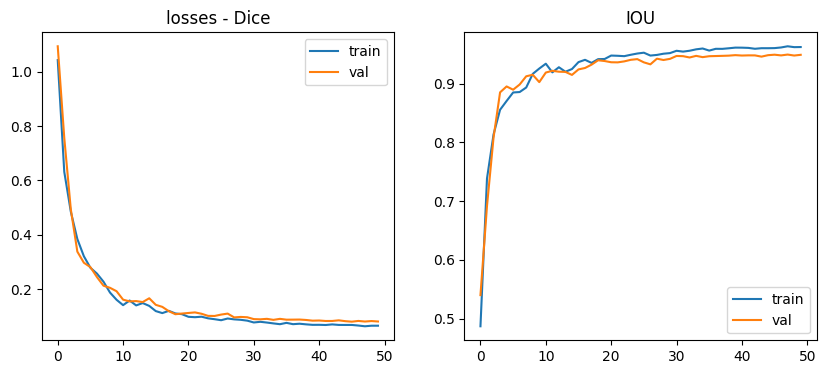

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(loss_logs["train"], label = "train")
axes[0].plot(loss_logs["val"], label = "val")
axes[0].set_title("losses - Dice")

axes[1].plot(metric_logs["train"], label = "train")
axes[1].plot(metric_logs["val"], label = "val")
axes[1].set_title("IOU")

[ax.legend() for ax in axes];

In [24]:
best_model = torch.jit.load('/kaggle/working/best_unet_model.pth', map_location=DEVICE)

In [25]:
def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=0, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)

In [26]:
# оценка IoU
test_dataset = CarDataset(
    val_names, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 43/43 [00:02<00:00, 17.02it/s, dice_loss + bce_loss - 0.06542, fscore - 0.978, iou_score - 0.9577] 


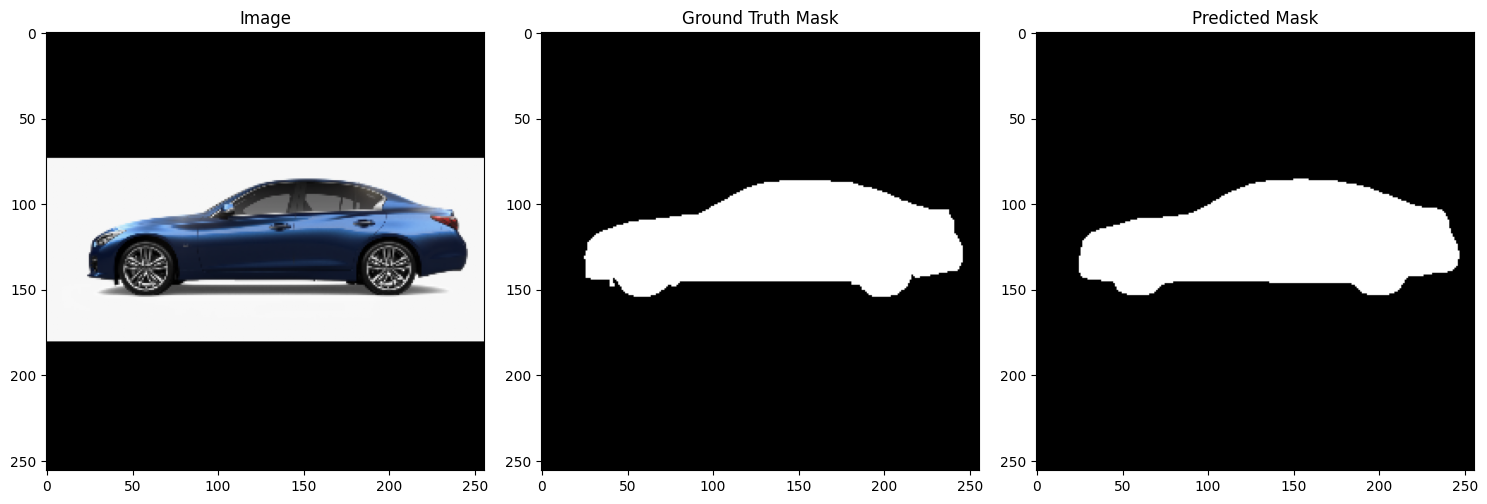

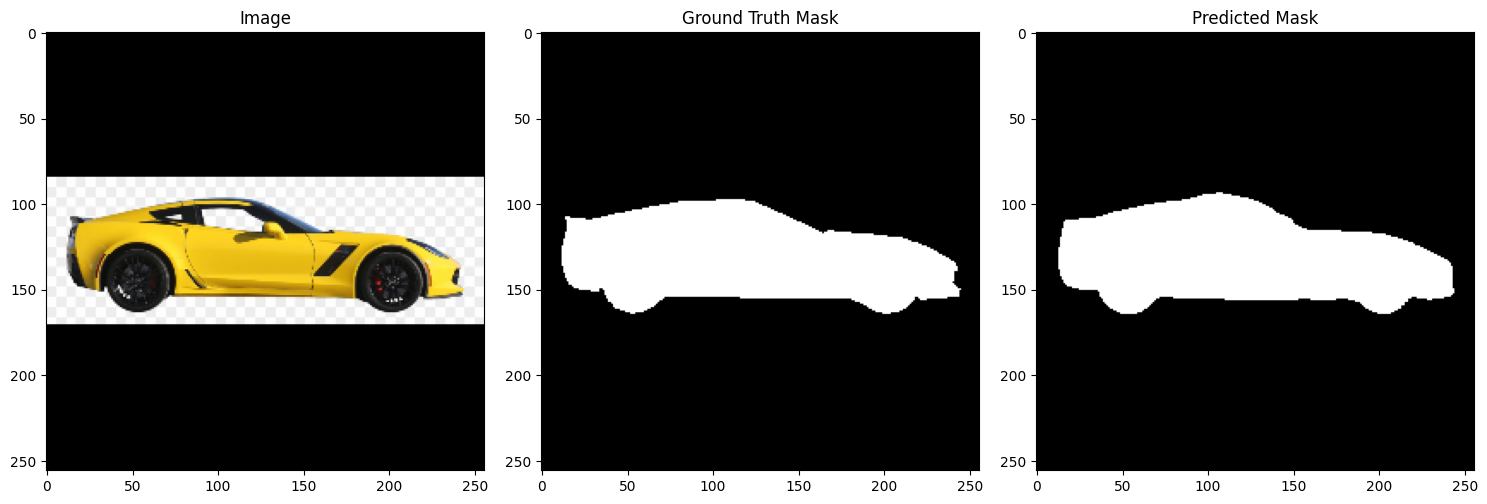

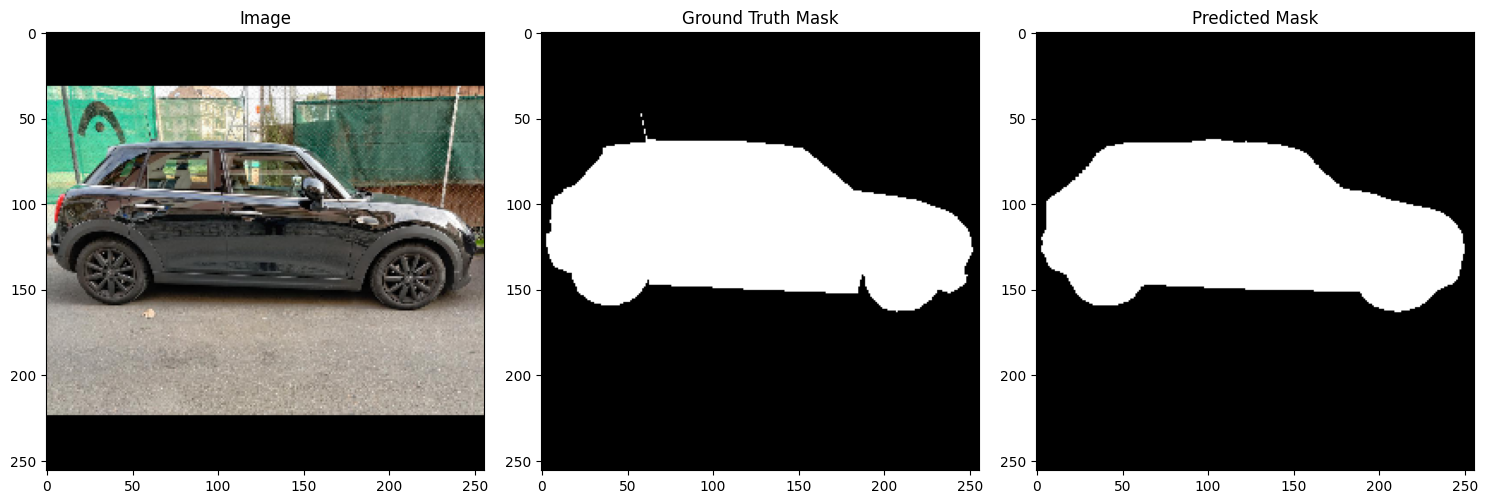

In [36]:
best_model.to(DEVICE)
best_model.eval()


test_dataset_vis = CarDataset(
    val_names, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(lambda x, **kwargs: x)
)

In [39]:
def reverse_normalize(img, mean, std):
    img = img.transpose(1, 2, 0)
    img = img * np.array(std) + np.array(mean)
    img = np.clip(img, 0, 1)
    return img

def visualize_predicts(img: np.ndarray, gt_mask: np.ndarray, pr_mask: np.ndarray, normalized=False):
    _, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    if normalized:
        display_img = reverse_normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        display_img = img.transpose(1, 2, 0) / 255.0
        
    axes[0].imshow(np.clip(display_img, 0, 1))
    axes[0].set_title("Image")
    
    axes[1].imshow(gt_mask.squeeze(), cmap='gray')
    axes[1].set_title("Ground Truth Mask")

    axes[2].imshow(pr_mask.squeeze(), cmap='gray')
    axes[2].set_title("Predicted Mask")
    overlaid = apply_mask_overlay(display_img, pr_mask.squeeze(), color=(255, 0, 0), alpha=0.4) # Красный цвет
    axes[3].imshow(overlaid)
    axes[3].set_title("Image with Overlay")
    
    plt.tight_layout()
    plt.show()

In [38]:
def apply_mask_overlay(image, mask, color=(0, 255, 0), alpha=0.5):
    colored_mask = np.zeros_like(image, dtype=np.uint8)
    colored_mask[mask] = color
    
    image_bgr = (image * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2BGR)

    overlaid_image = cv2.addWeighted(image_bgr, 1 - alpha, colored_mask, alpha, 0)
    
    overlaid_image_rgb = cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB)
    
    return overlaid_image_rgb

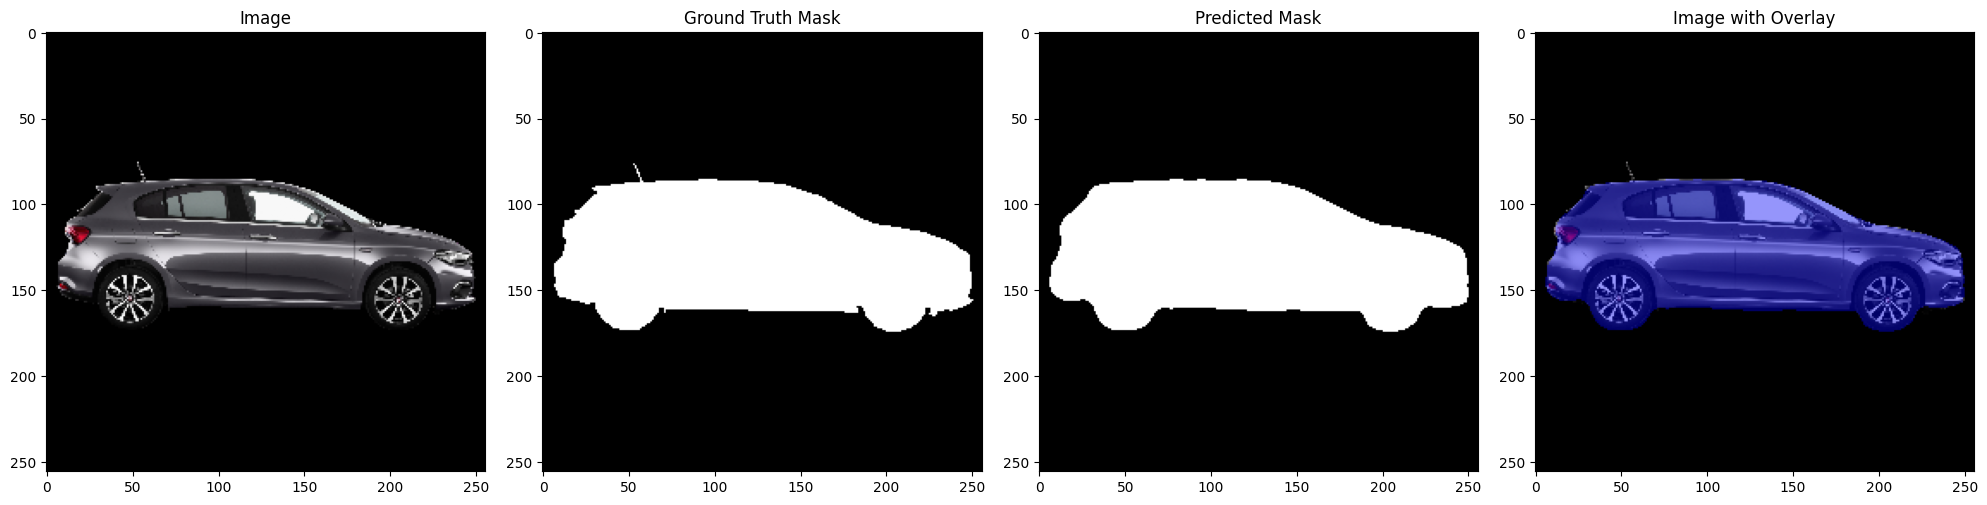

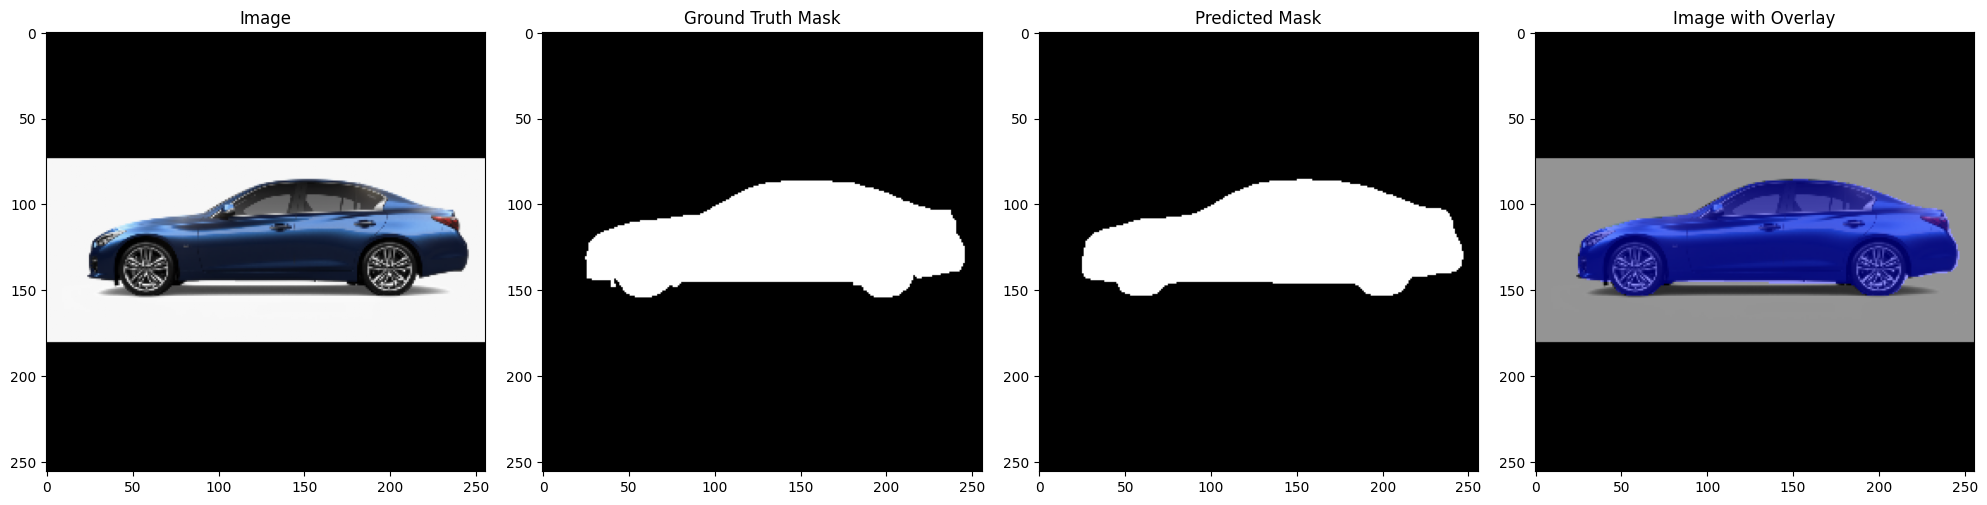

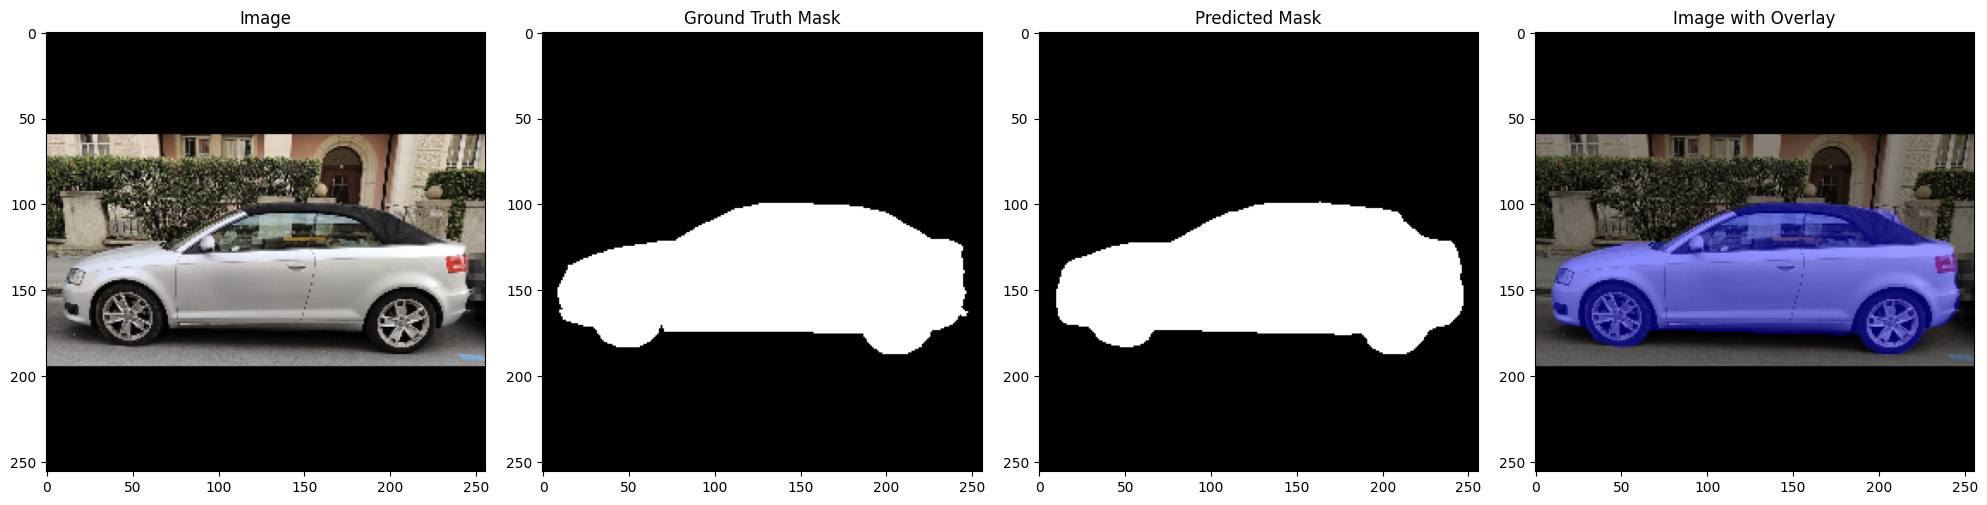

In [40]:
for i in range(3):
    n = np.random.choice(len(test_dataset_vis))
    
    image_vis, gt_mask_vis = test_dataset_vis[n]
    
    image_tensor, gt_mask_tensor = test_dataset[n]
    
    x_tensor = torch.from_numpy(image_tensor).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        pr_mask_tensor = best_model(x_tensor)

    pr_mask = pr_mask_tensor.squeeze().cpu().numpy()
    
    gt_mask_binary = gt_mask_vis.squeeze() > 0.5
    pr_mask_binary = pr_mask > 0.5
    
    visualize_predicts(
        img=image_vis,
        gt_mask=gt_mask_binary,
        pr_mask=pr_mask_binary,
        normalized=False
    )